In [23]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import nltk
import time
import json
import os

In [3]:
def DataAggregator(path):
    text_dict = {}
    json_dict = {}
    label_df = pd.DataFrame(columns=['changes', 'positions','file'])

    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(path+file, 'r', encoding='utf-8') as myfile:
                text_dict[file.replace('problem-', '').replace('.txt', '')] = myfile.read().replace('\n', '')
        else:
            with open(path+file, 'r', encoding='utf-8') as myfile:
                data = json.load(myfile)
                json_dict[file.replace('problem-', '').replace('.truth', '')] = data['changes']

    df = pd.DataFrame(list(text_dict.items()), columns=['file', 'text'])
    label_df = pd.DataFrame(list(json_dict.items()), columns = ['file', 'changes'])

    output_df = df.merge(label_df,on='file')
    output_df = output_df.drop('file', axis = 1)
    return output_df

In [4]:
#Convert the data sets to data frames
test_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-test-dataset-2018-01-31/')
training_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-training-dataset-2018-01-31/')
validation_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-validation-dataset-2018-01-31/')


In [5]:
#Split the data into text and labels
training_labels = training_df['changes']
validation_labels = validation_df['changes']
test_labels = test_df['changes']

training_text = list(training_df['text'])
validation_text = list(validation_df['text'])
test_text = list(test_df['text'])

print("Training Text: " + str(len(training_text)) + ", Training Labels: " + str(len(training_labels)))
print("Test Text: " + str(len(test_text)) + ", Test Labels: " + str(len(test_labels)))
print("Validation Text: " + str(len(validation_text)) + ", Validation Labels: " + str(len(validation_labels)))

Training Text: 2980, Training Labels: 2980
Test Text: 1352, Test Labels: 1352
Validation Text: 1492, Validation Labels: 1492


In [49]:
#Builds a pipeline

NB_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                        ('tfidf', TfidfTransformer()),
                        ('clf', BernoulliNB())])

SVC_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SVC(C=0.5, probability=True))])

KNN_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', KNeighborsClassifier(10))])

In [50]:
#Train the models and fit to the validation set
start = time.time()
nb_proba = NB_pipeline.fit(training_text, training_labels).predict_proba(validation_text)
nb_prediction = NB_pipeline.predict(validation_text)
print("Naive Bayes Accuracy: " + str(metrics.accuracy_score(nb_prediction, validation_labels)) + " -- Run time " + str(time.time()-start))
nb_confusion = metrics.confusion_matrix(validation_labels, nb_prediction)
print(nb_confusion)

start = time.time()
svc_proba = SVC_pipeline.fit(training_text, training_labels).predict_proba(validation_text)
svc_prediction = SVC_pipeline.predict(validation_text)
print("SVC Accuracy: " + str(metrics.accuracy_score(svc_prediction, validation_labels)) + " -- Run time " + str(time.time()-start))
svc_confusion = metrics.confusion_matrix(validation_labels, svc_prediction)
print(svc_confusion)


start = time.time()
knn_proba = KNN_pipeline.fit(training_text, training_labels).predict_proba(validation_text)
knn_prediction = KNN_pipeline.predict(validation_text)
print("KNN Accuracy: " + str(metrics.accuracy_score(knn_prediction, validation_labels)) + " -- Run time " + str(time.time()-start))
knn_confusion = metrics.confusion_matrix(validation_labels, knn_prediction)
print(knn_confusion)


Naive Bayes Accuracy: 0.881367292225 -- Run time 29.98414134979248
[[695  51]
 [126 620]]
SVC Accuracy: 0.560321715818 -- Run time 387.32756543159485
[[745   1]
 [655  91]]
KNN Accuracy: 0.504691689008 -- Run time 28.261860132217407
[[746   0]
 [739   7]]


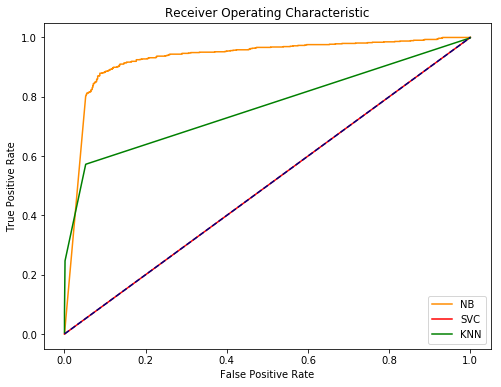

In [51]:
nb_fpr, nb_tpr, __ = metrics.roc_curve(validation_labels, nb_proba[:,1])
svc_fpr, svc_tpr, __ = metrics.roc_curve(validation_labels, svc_proba[:,1])
knn_fpr, knn_tpr, __ = metrics.roc_curve(validation_labels, knn_proba[:,1])

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.plot(nb_fpr, nb_tpr, color='darkorange', label='NB')
plt.plot(svc_fpr, svc_tpr, color = 'red', label='SVC')
plt.plot(knn_fpr, knn_tpr, color = 'green', label = 'KNN')
ax.plot([0,1], [0,1], 'r--', color='navy')

ax.legend(loc="lower right")


plt.show()